In [1]:
%load_ext lab_black

In [2]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from icecream import ic

import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()
import pickle
from include.generators import ScaleDataGen, InvDataGen
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation
import model_eval
from typing import List, Optional
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm
import tensorflow as tf
from matplotlib_functions import setMatplotlibParam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass, field

sys.path.append("/cerea_raid/users/dumontj/dev/coco2/data_build/vis")
from plot_PS import set_subfigs

from keras import backend as K

from models.preprocessing import (
    CloudsLayer,
    ConditionalNoiseLayer,
    TrainingTimeNormalization,
)

2024-01-12 11:52:46.887427: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 11:52:46.924757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 11:52:46.924786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 11:52:46.924804: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 11:52:46.931854: I tensorflow/core/platform/cpu_feature_g

<Figure size 1920x1440 with 0 Axes>

## Test on Data object

In [3]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_32/dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip_32/dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_32/dataset.nc"

In [4]:
data = Data_train(path_train_nc, path_valid_nc, path_extra_valid_nc)
data.prepare_input("xco2", "u_wind", "v_wind", "no2", clouds_threshold=0.87)
data.prepare_output_inversion()

TypeError: __init__() missing 1 required positional argument: 'timedate'

## Experiments with ds

In [14]:
ds = xr.open_dataset("/libre/dumontj/coco2/dl-input/2km_Lip_32/dataset.nc")

### Check emission patterns

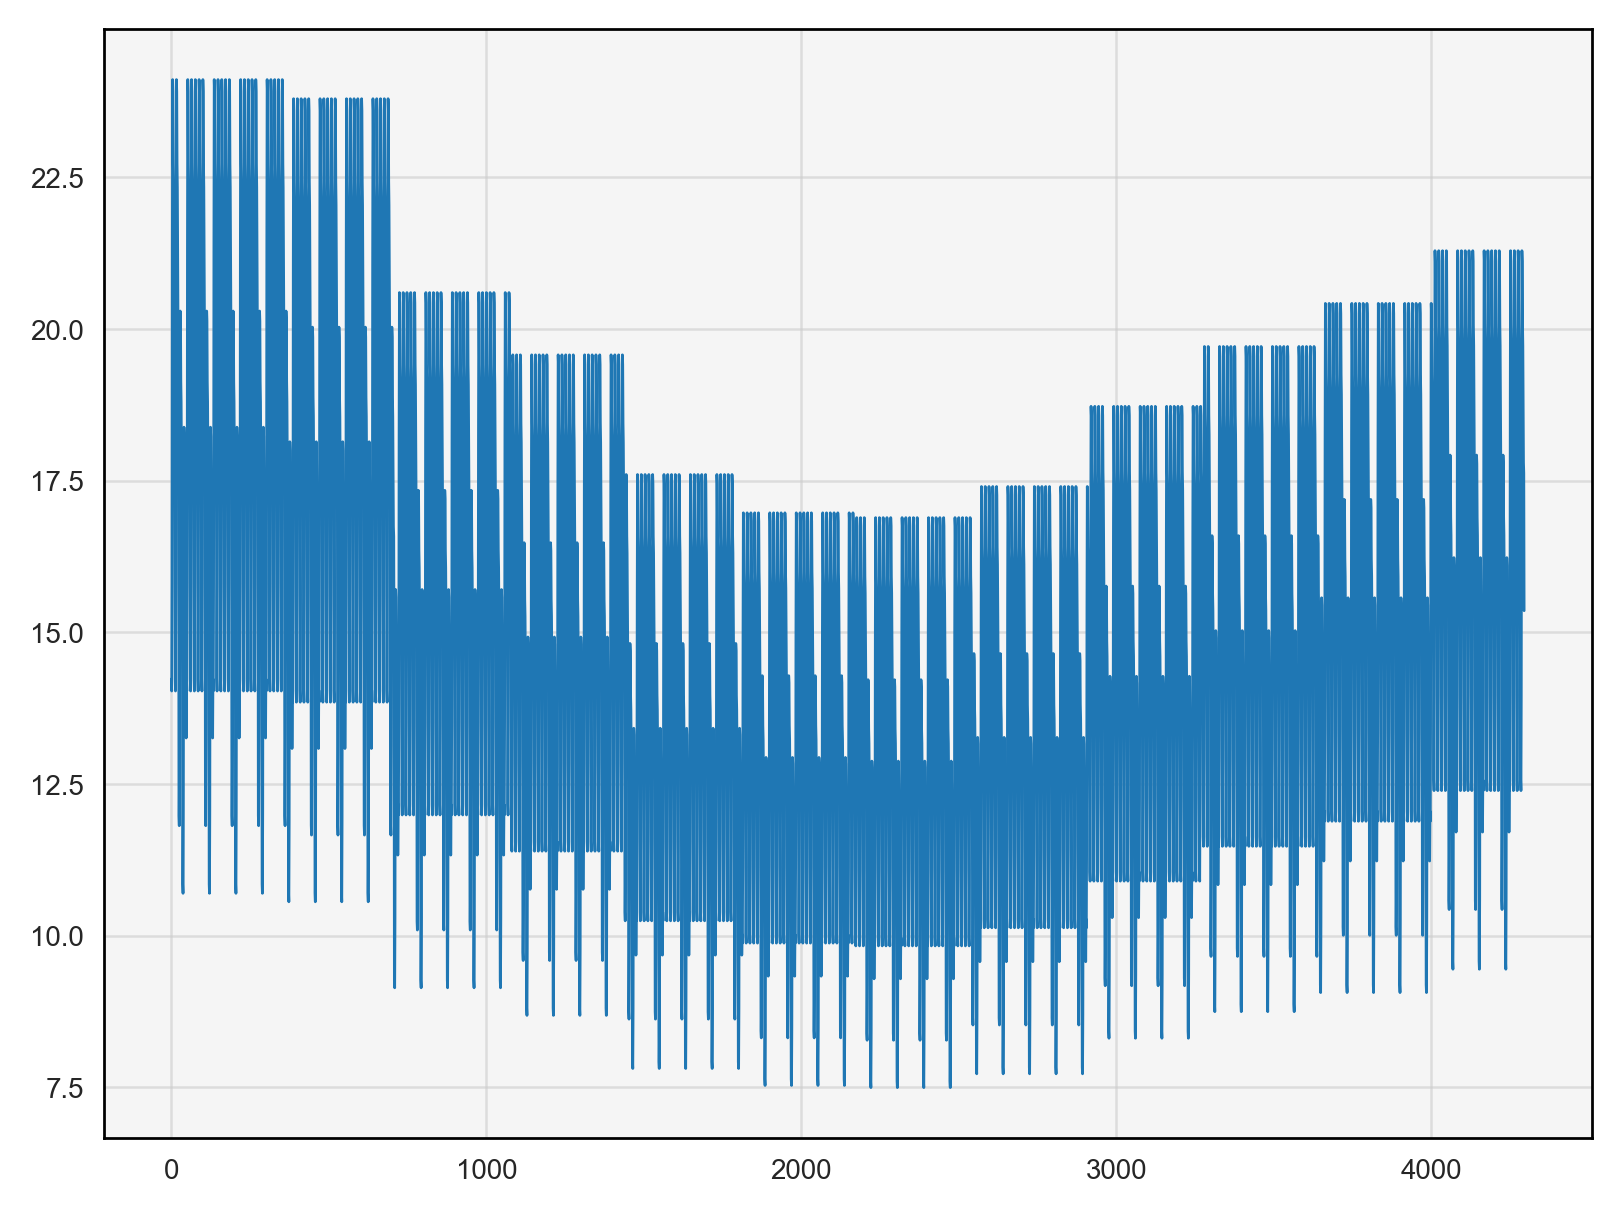

In [15]:
plt.plot(ds.emiss.values[:, 0])

In [8]:
data_series = ds.emiss.values[:, 0]

In [9]:
data_series = ds.emiss.values[:, 0]
start_date = pd.to_datetime(ds.time[0].values)
dates = pd.date_range(
    start=start_date, periods=len(data_series), freq="2H"
)  # 2-hour frequency

In [10]:
df = pd.DataFrame({"Date": dates, "Value": data_series})
df.set_index("Date", inplace=True)

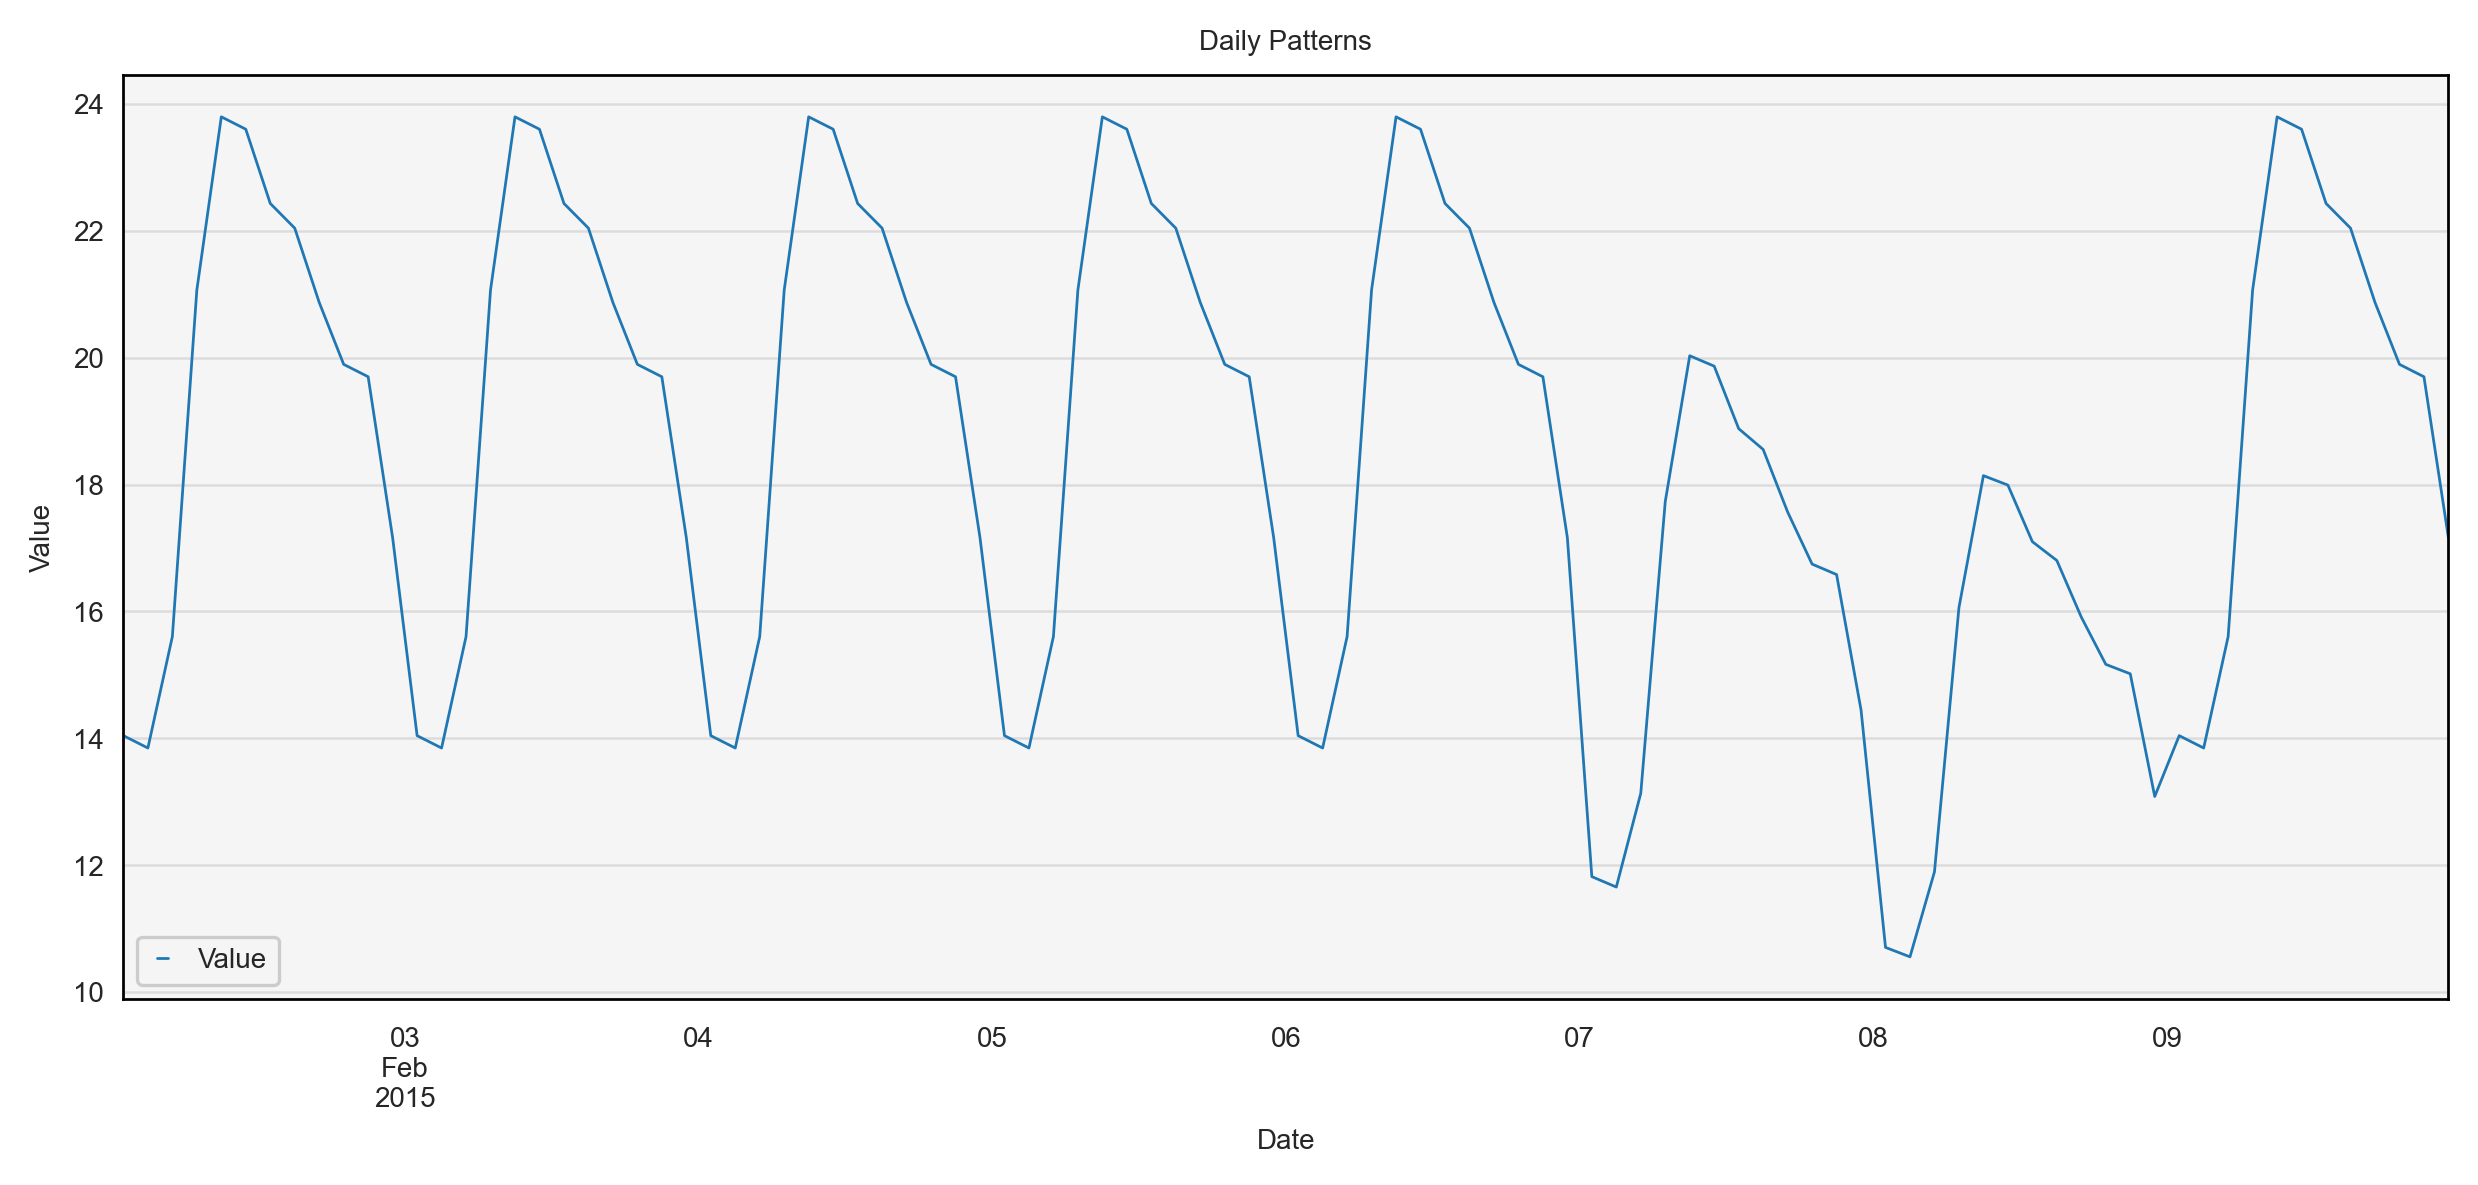

In [11]:
df.iloc[48 * 8 : 48 * 10].plot(figsize=(10, 4))  # 48 data points cover two days
plt.title("Daily Patterns")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

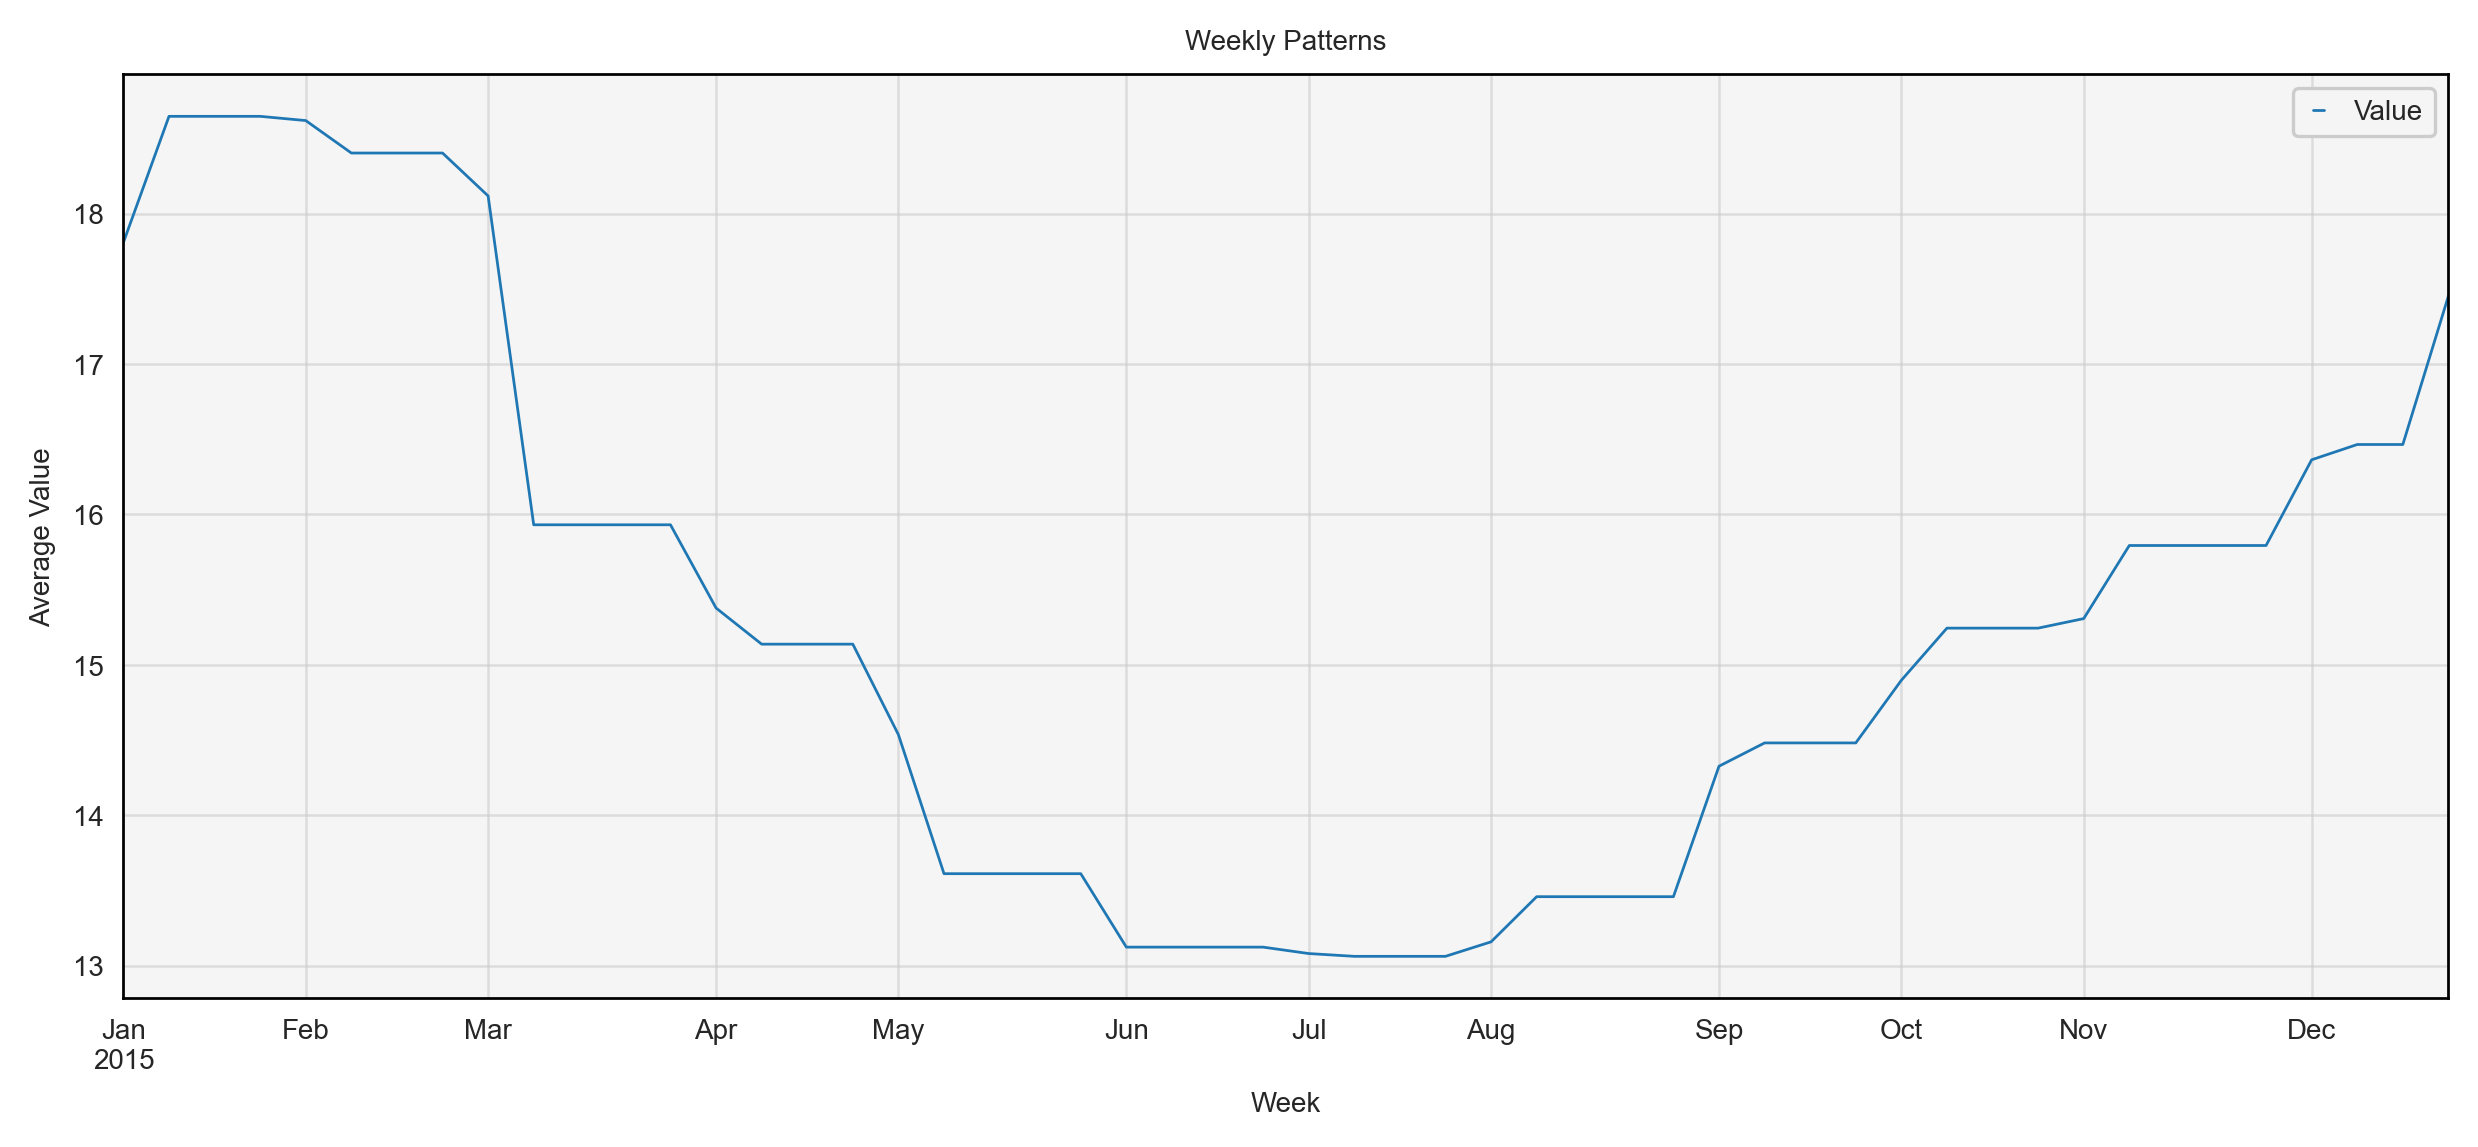

In [12]:
# Weekly Patterns
weekly_data = df.resample("W").mean()
weekly_data.plot(figsize=(10, 4))
plt.title("Weekly Patterns")
plt.xlabel("Week")
plt.ylabel("Average Value")
plt.show()

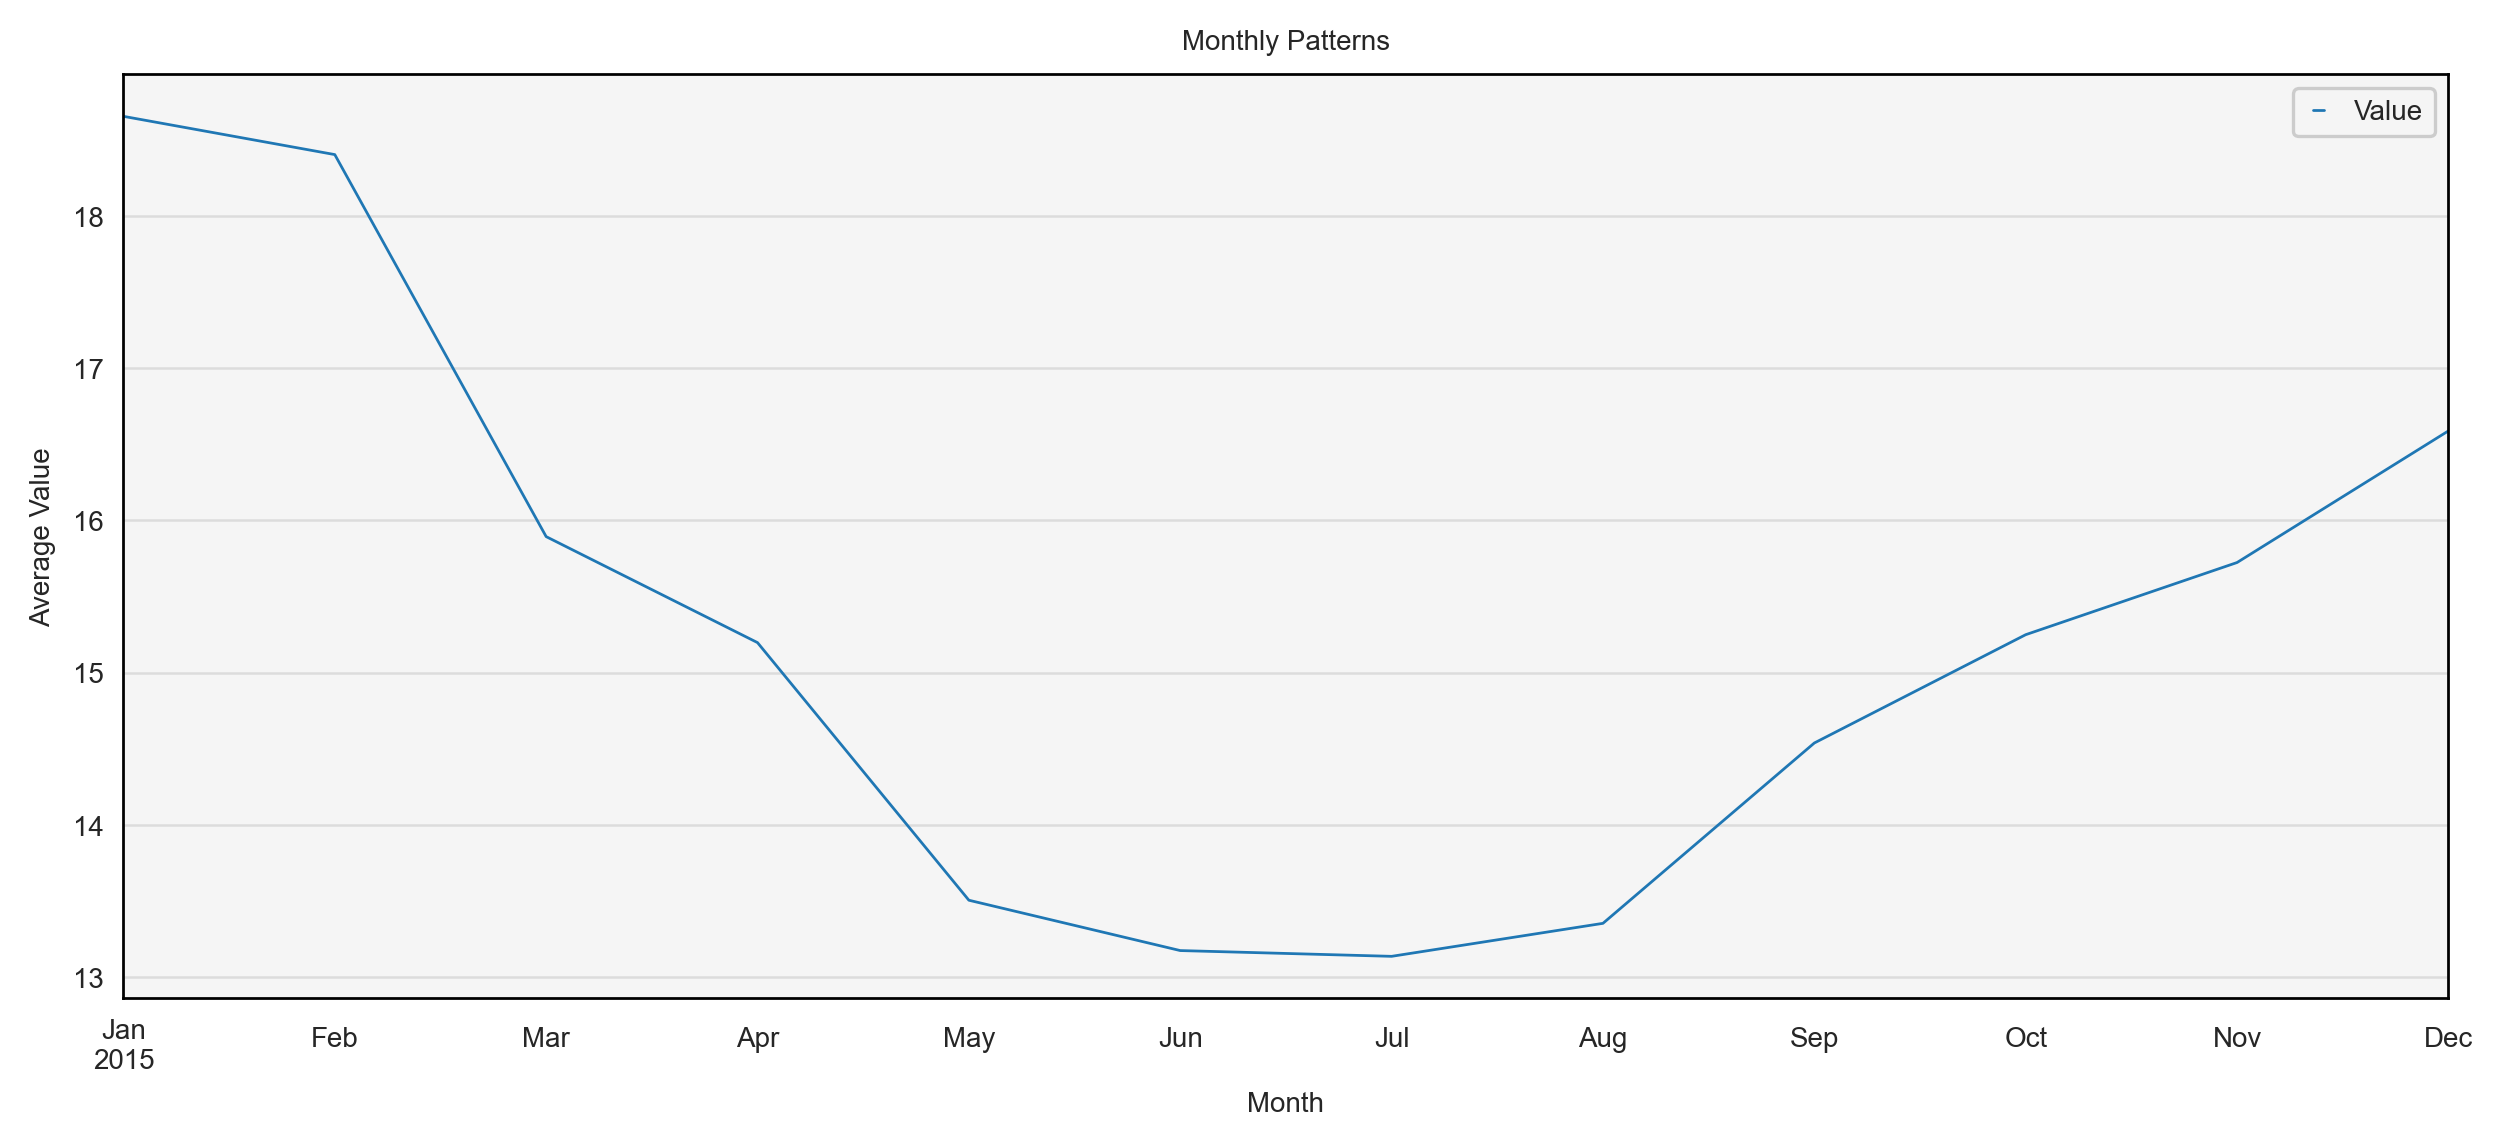

In [13]:
# Monthly Patterns
monthly_data = df.resample("M").mean()
monthly_data.plot(figsize=(10, 4))
plt.title("Monthly Patterns")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.show()

### Timedate preprocessing analysis

In [40]:
ds["time"].dt.weekday

<xarray.DataArray 'dayofweek' (idx_img: 4296)>
array([3, 3, 3, ..., 3, 3, 3])
Coordinates:
  * idx_img  (idx_img) int32 0 1 2 3 4 5 6 ... 4290 4291 4292 4293 4294 4295

In [35]:

ds["time"].dt.day
ds["time"].dt.month
ds["time"].dt.dayofyear

<xarray.DataArray 'dayofyear' (idx_img: 4296)>
array([  1,   1,   1, ..., 358, 358, 358])
Coordinates:
  * idx_img  (idx_img) int32 0 1 2 3 4 5 6 ... 4290 4291 4292 4293 4294 4295

In [69]:
def get_timedate_vector(ds: xr.Dataset):
    """Get timedate vector in an xarray dataset"""

    hours_in_day = 24
    days_in_week = 7
    days_in_year = 365

    hour_angle = 2 * np.pi * ds["time"].dt.hour.values / hours_in_day
    weekday_angle = 2 * np.pi * ds["time"].dt.weekday.values / days_in_week
    yearday_angle = 2 * np.pi * ds["time"].dt.dayofyear.values / days_in_year

    timedate_vector = np.array(
        [
            np.cos(hour_angle),
            np.sin(hour_angle),
            np.cos(weekday_angle),
            np.sin(weekday_angle),
            np.cos(yearday_angle),
            np.sin(yearday_angle),
        ]
    ).T

    return timedate_vector


timedate_vector = get_timedate_vector(ds)
timedate_vector.shape

(4296, 6)

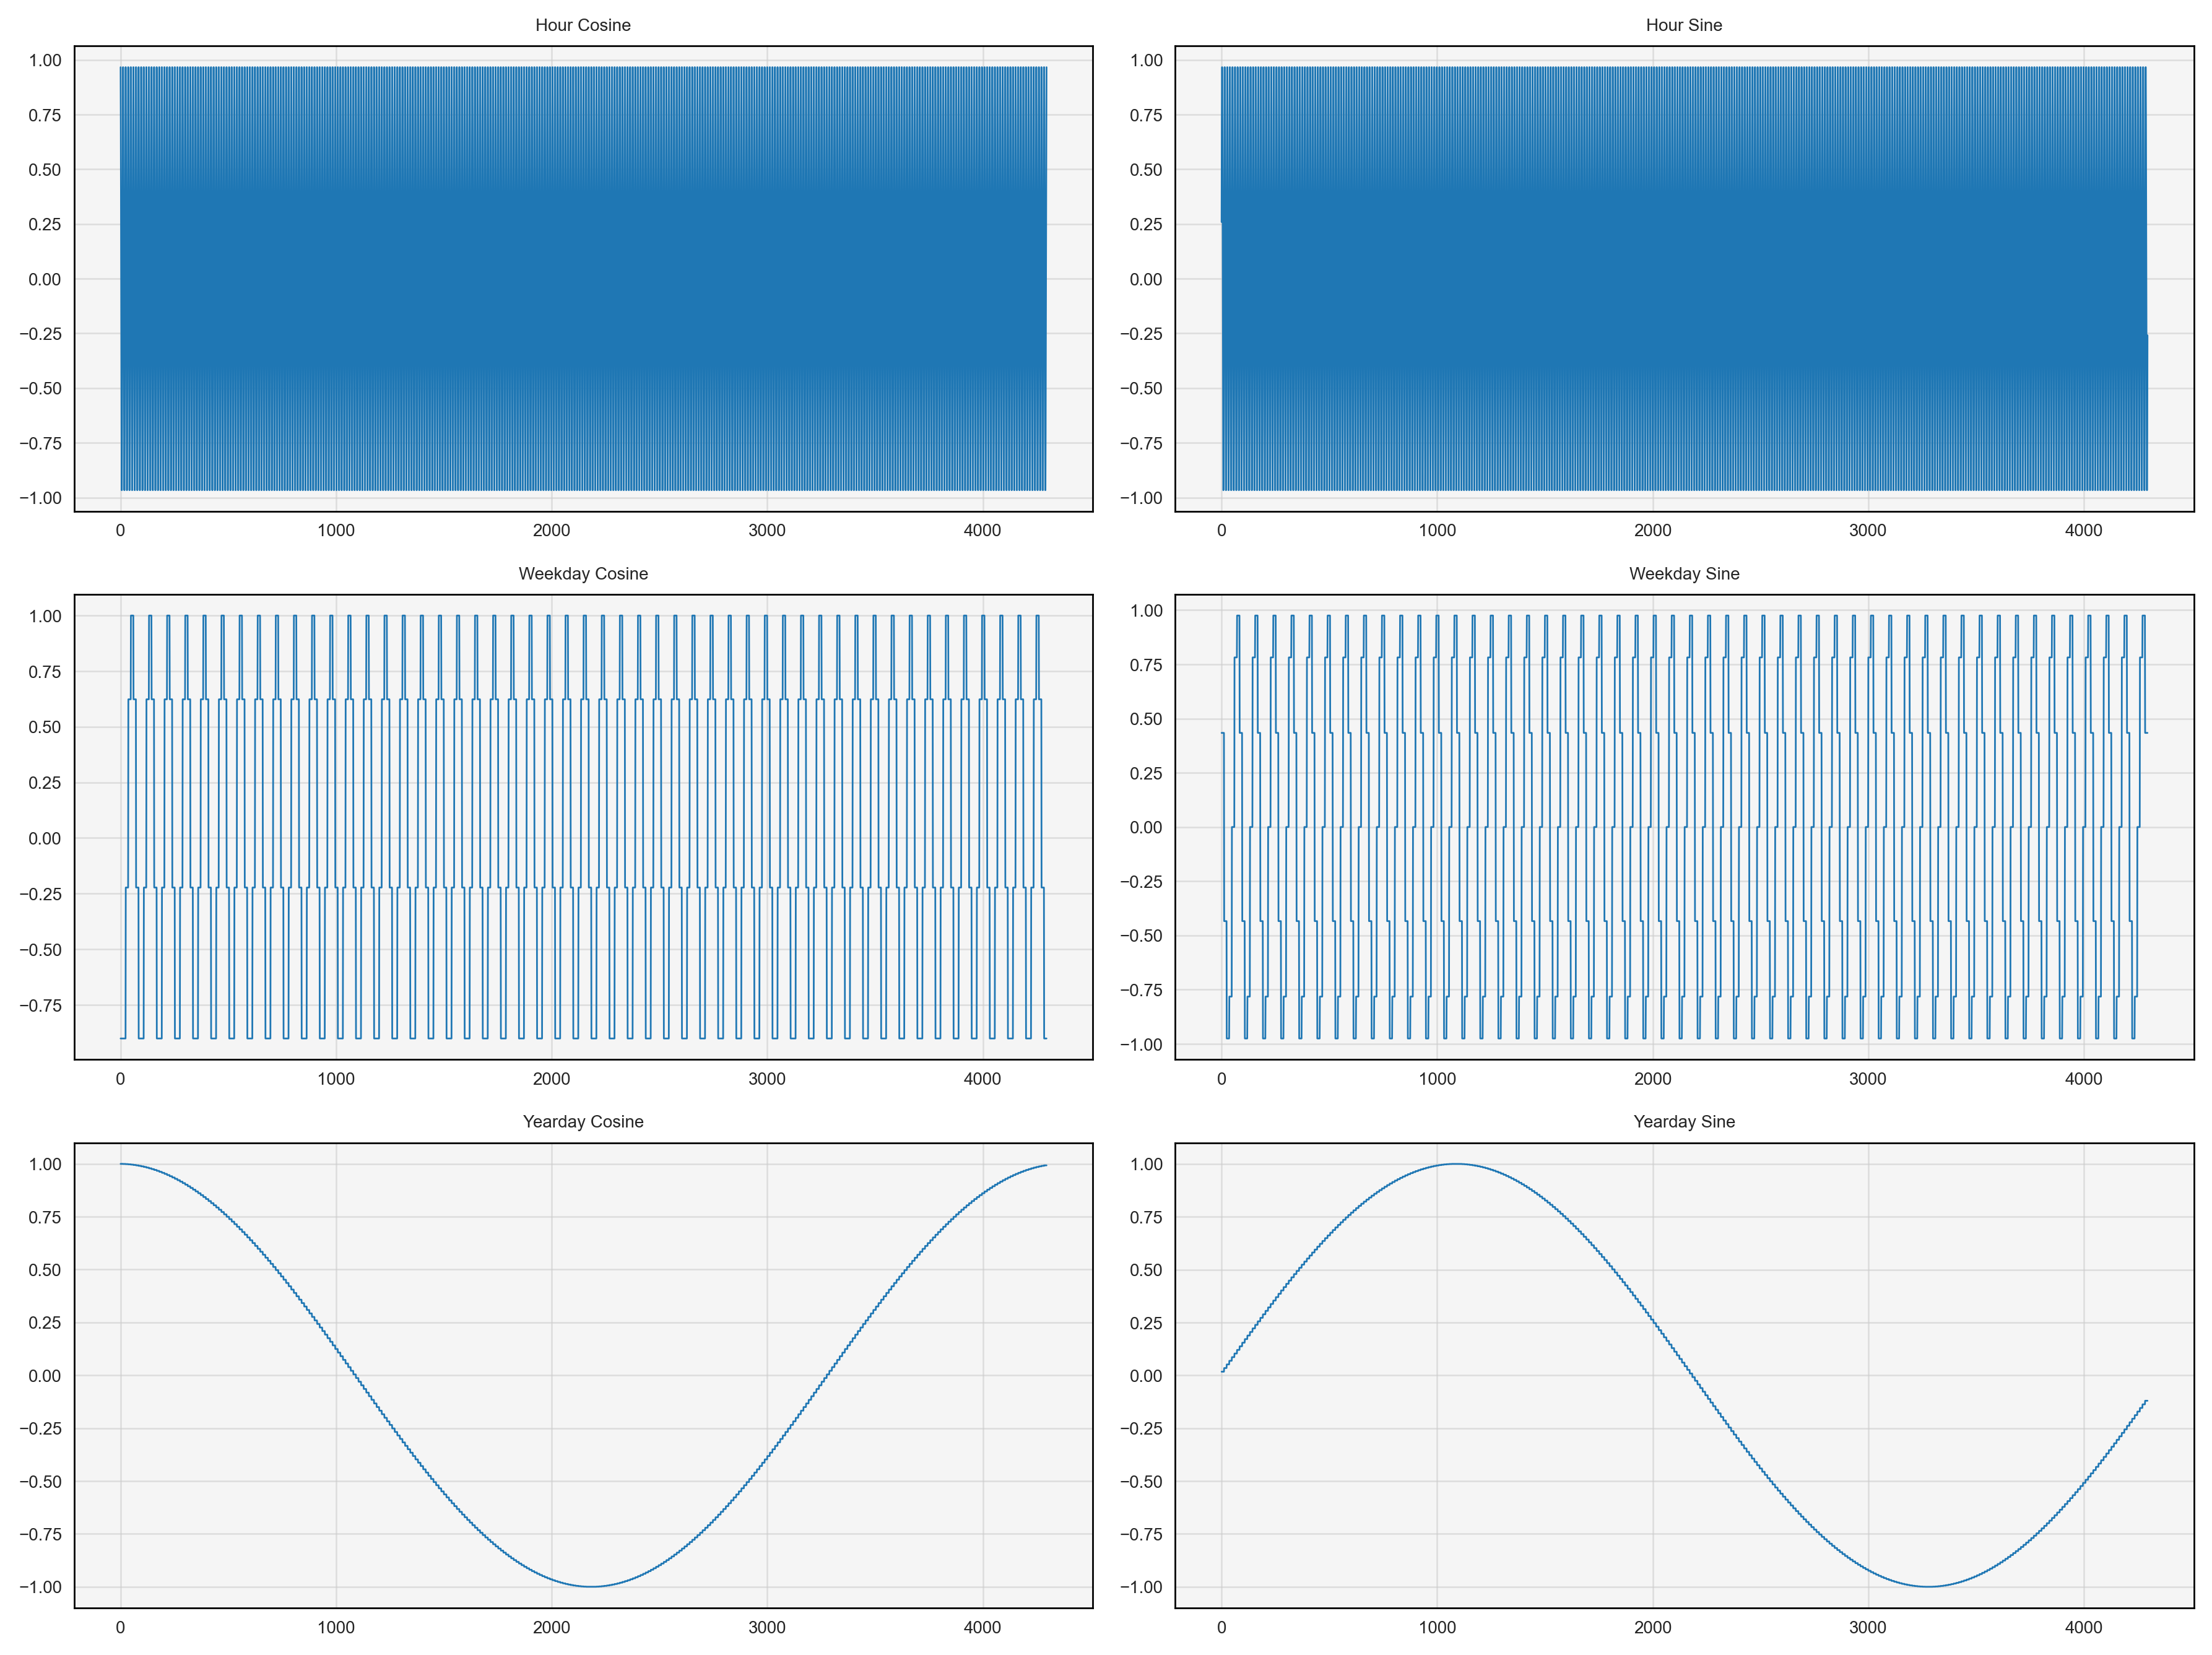

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
titles = [
    "Hour Cosine",
    "Hour Sine",
    "Weekday Cosine",
    "Weekday Sine",
    "Yearday Cosine",
    "Yearday Sine",
]

for i, ax in enumerate(axes.flatten()):
    ax.plot(timedate_vector[:, i])
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

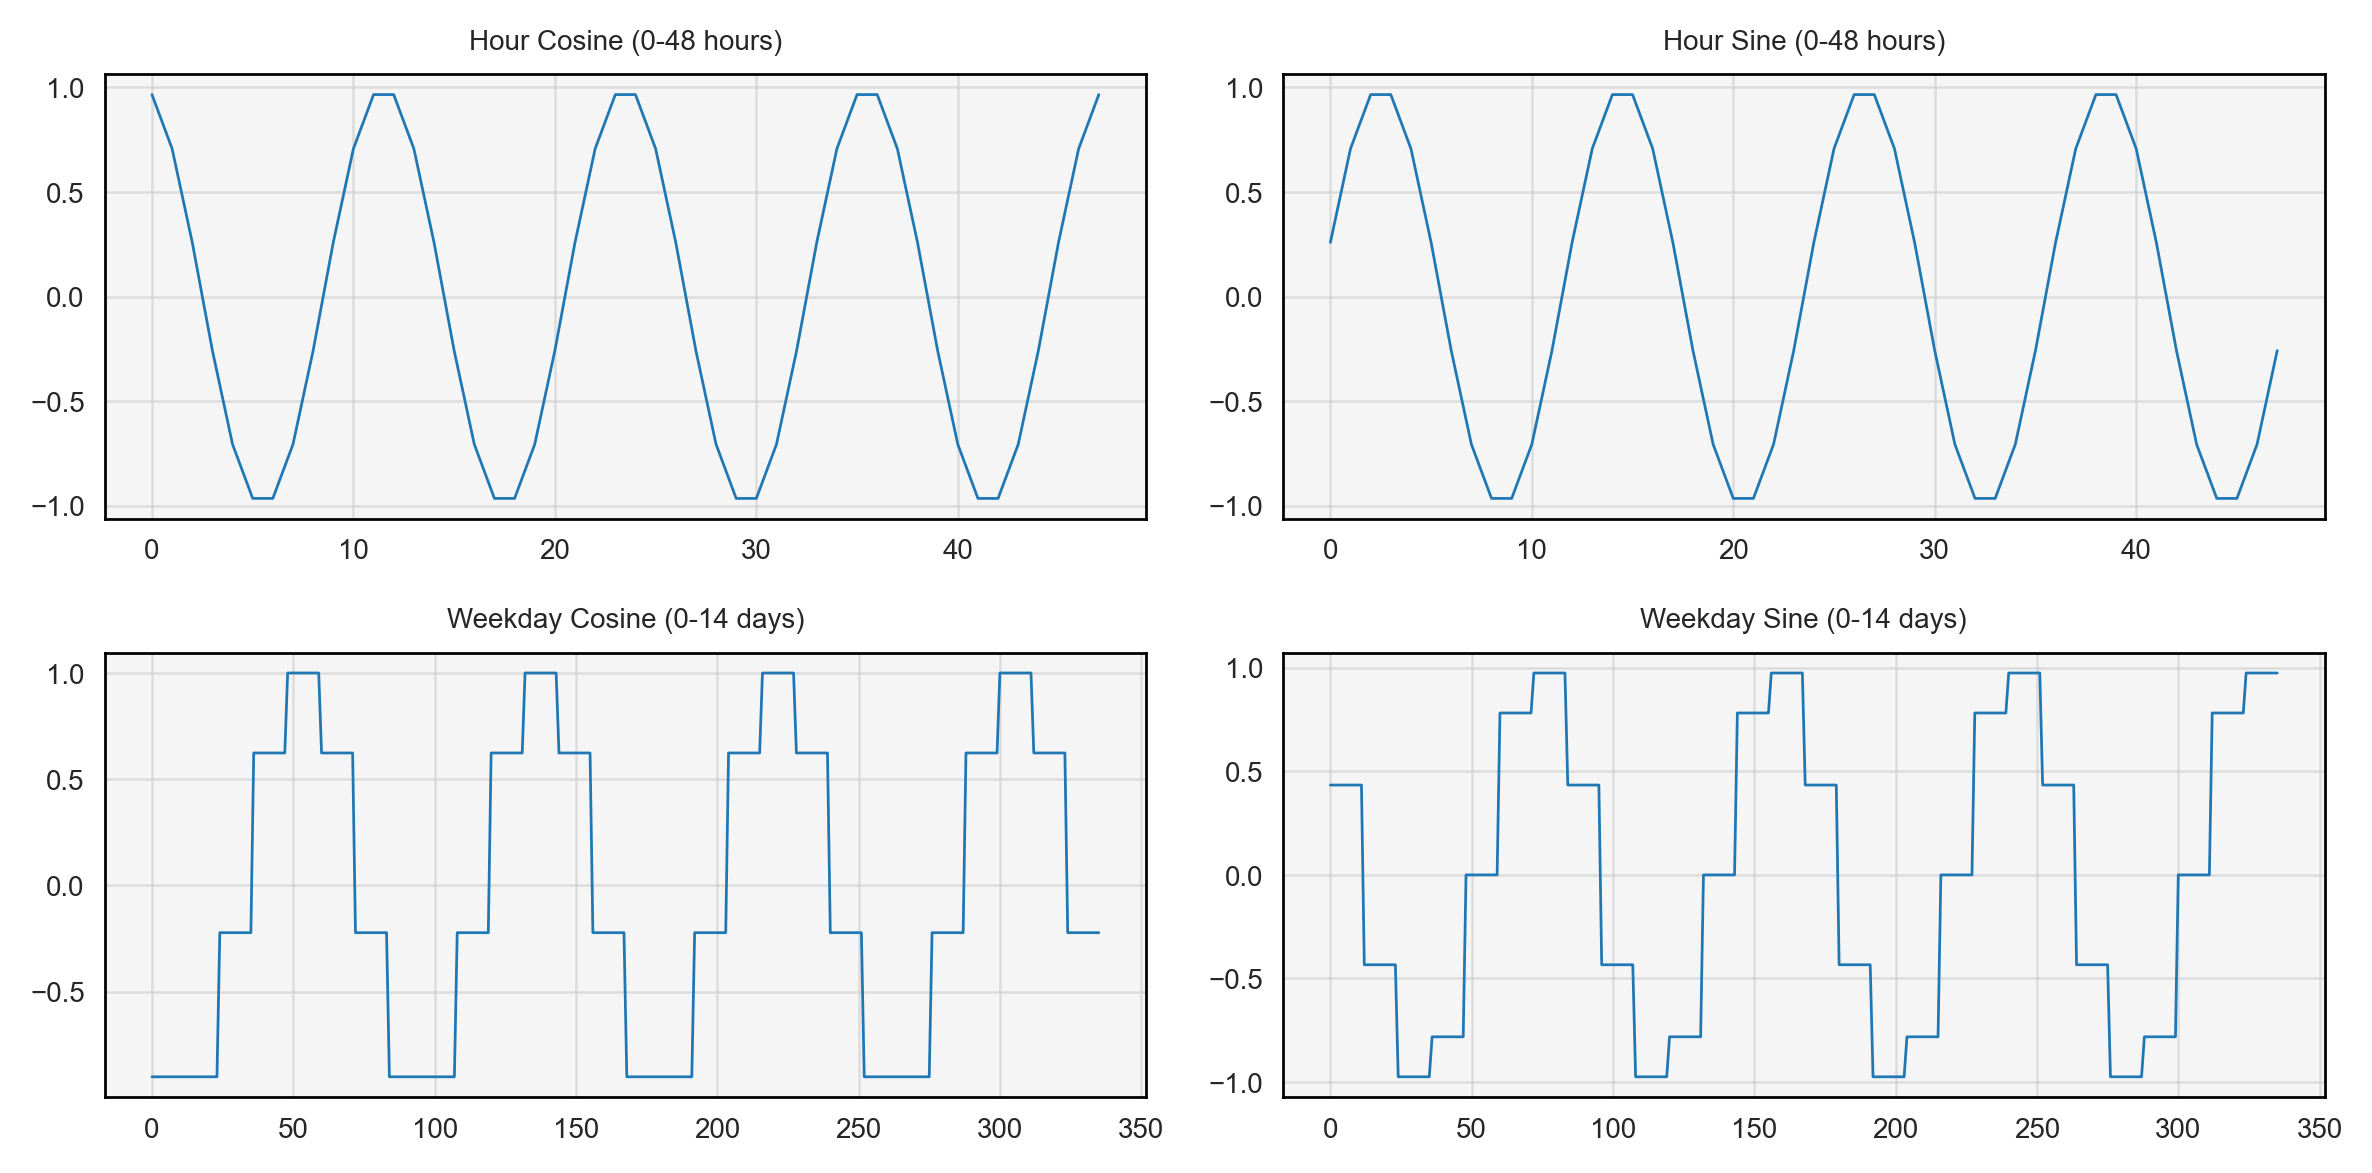

In [71]:
hour_timedate_vector = get_timedate_vector(ds)[:, 0:2]
weekday_timedate_vector = get_timedate_vector(ds)[:, 2:4]

# Plotting the variables for hour and weekday
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# Hour plots
axes[0, 0].plot(hour_timedate_vector[:, 0][0:48], label="Cosine")
axes[0, 0].set_title("Hour Cosine (0-48 hours)")
axes[0, 1].plot(hour_timedate_vector[:, 1][0:48], label="Sine")
axes[0, 1].set_title("Hour Sine (0-48 hours)")

# Weekday plots
axes[1, 0].plot(weekday_timedate_vector[:, 0][24 * 0 : 24 * (14)], label="Cosine")
axes[1, 0].set_title("Weekday Cosine (0-14 days)")
axes[1, 1].plot(weekday_timedate_vector[:, 1][24 * 0 : 24 * (14)], label="Sine")
axes[1, 1].set_title("Weekday Sine (0-14 days)")

plt.tight_layout()
plt.show()

### Normalisation

In [75]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalised_timedate_vector = scaler.fit_transform(timedate_vector)
normalised_timedate_vector.shape

(4296, 6)

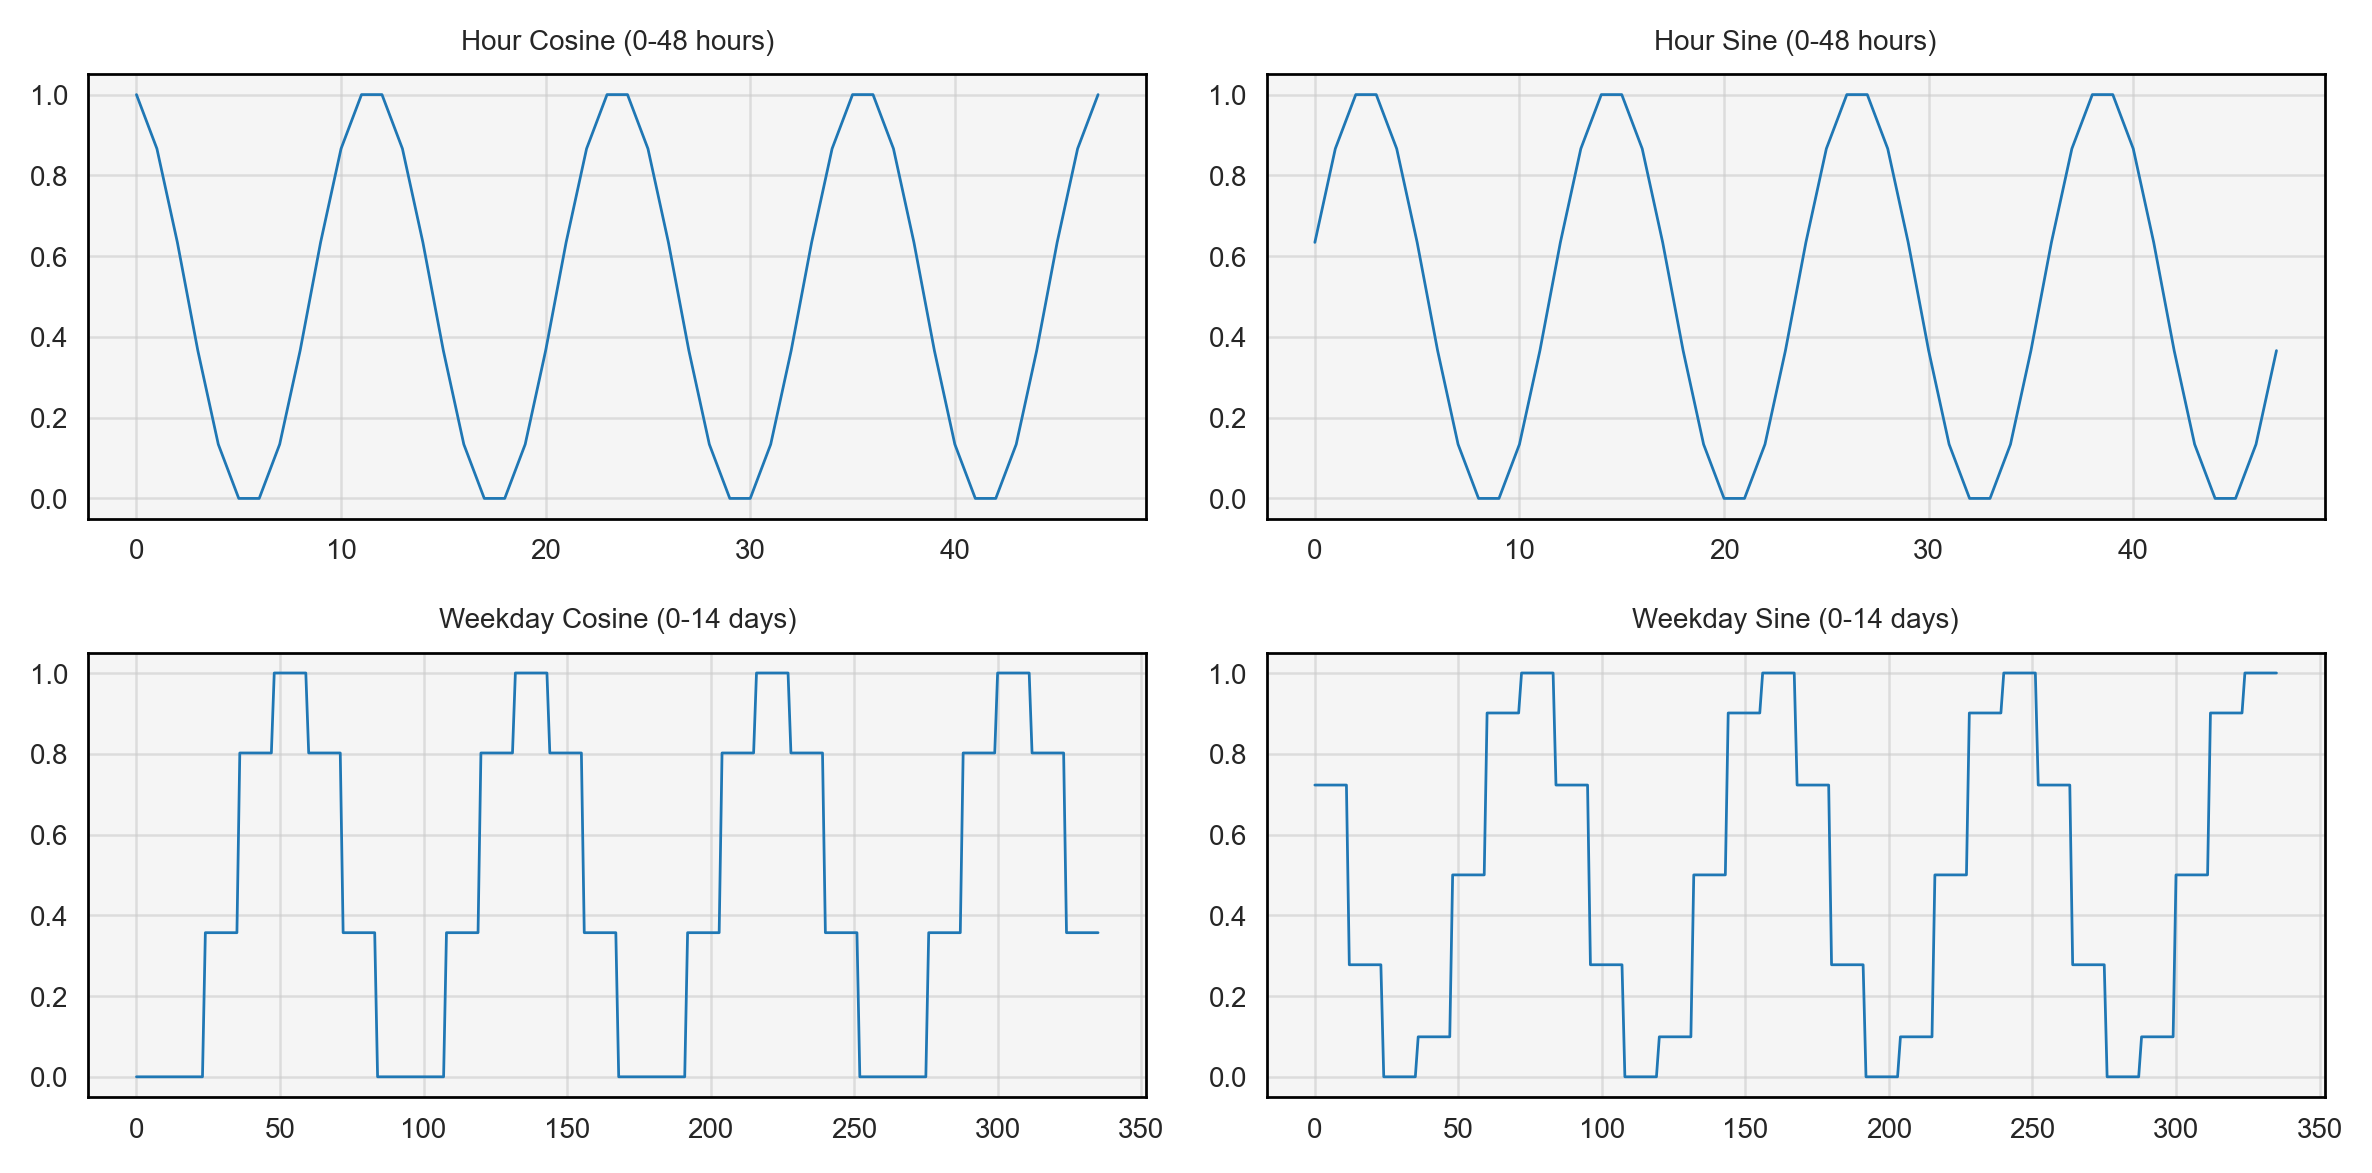

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# Hour plots
axes[0, 0].plot(normalised_timedate_vector[:, 0][0:48], label="Cosine")
axes[0, 0].set_title("Hour Cosine (0-48 hours)")
axes[0, 1].plot(normalised_timedate_vector[:, 1][0:48], label="Sine")
axes[0, 1].set_title("Hour Sine (0-48 hours)")

# Weekday plots
axes[1, 0].plot(normalised_timedate_vector[:, 2][24 * 0 : 24 * (14)], label="Cosine")
axes[1, 0].set_title("Weekday Cosine (0-14 days)")
axes[1, 1].plot(normalised_timedate_vector[:, 3][24 * 0 : 24 * (14)], label="Sine")
axes[1, 1].set_title("Weekday Sine (0-14 days)")

plt.tight_layout()
plt.show()

In [80]:
normalised_timedate_vector.shape

(4296, 6)